In [1]:
# Import torch
import torch

# check for nvidia gpu
!nvidia-smi

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

print(f"Device: {device}")

zsh:1: command not found: nvidia-smi
Device: cpu


In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

NUM_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=NUM_SAMPLES,
                  noise=0.07,
                  random_state=RANDOM_SEED)

X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [3]:
# Turn data into a DataFrame
import pandas as pd

moons = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                       "label": y})
moons.head(10)

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0
5,0.599064,-0.289773,1
6,0.290090,-0.204688,1
7,-0.038269,0.459429,1
8,1.613771,-0.293970,1
9,0.693337,0.827819,0


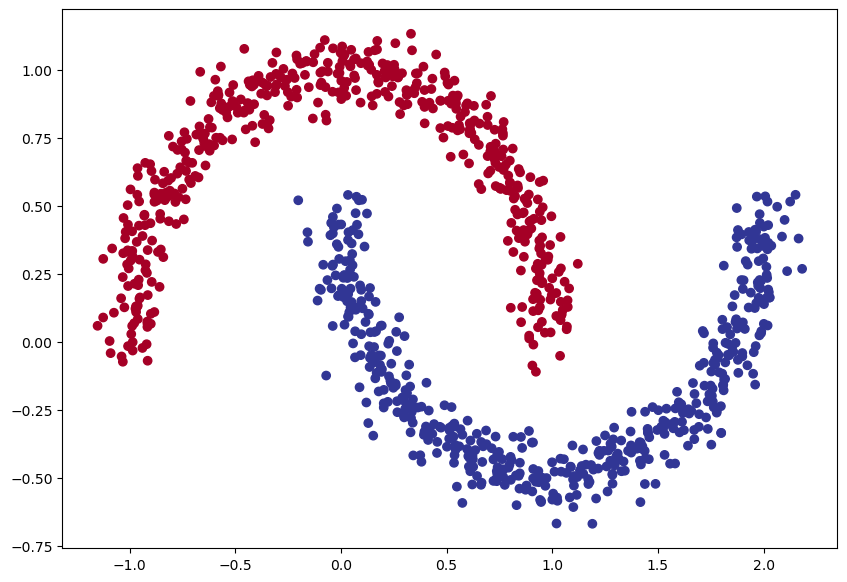

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

# plot data
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [5]:
# Turn data into tensors of dtype float

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [6]:
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, in_features, output_features, hidden_units=8):
        """Initialises multi-class classification model

        Args:
            input_features (int): Number of input features
            output_features (int): Number of output features
            hidden_units (int): Number of hidden units between layers, default 8

        Returns:

        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Instantiate the model
## Your code here ##

model_5 = MoonModelV0(in_features=2, output_features=1)
model_5

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [8]:
from torchmetrics import Accuracy

# Setup loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss() # sigmoid layer built-in

# Setup optimizer to optimize model's parameters
optimiser = torch.optim.SGD(params=model_5.parameters(), lr=0.01)

accuracy_fn = Accuracy(task="multiclass", num_classes=4).to(device)

In [9]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_5(X_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_5(X_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_5(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([-0.2479, -0.3645, -0.3080, -0.3022, -0.2582, -0.3092, -0.2410, -0.2717,
        -0.2585, -0.3424], grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.4383, 0.4099, 0.4236, 0.4250, 0.4358, 0.4233, 0.4400, 0.4325, 0.4357,
        0.4152], grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<RoundBackward0>)


In [10]:
epochs = 10001

y_train = y_train.float()
y_test = y_test.float()


for epoch in range(epochs):
    model_5.train()
    
    # Forward pass
    y_logits = model_5(X_train).squeeze()
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_probs)

    # Loss function
    loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

    # Accuracy
    acc = accuracy_fn(y_pred, y_train)

    # 3. Zero the gradients
    optimiser.zero_grad()

    # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
    loss.backward()

    # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
    optimiser.step()


    ### Testing
    model_5.eval() 
    
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_5(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate the loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred, y_test.int()) 

    # Print out what's happening
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.69 Acc: 0.50 | Test loss: 0.69 Test acc: 0.50
Epoch: 1000 | Loss: 0.36 Acc: 0.84 | Test loss: 0.38 Test acc: 0.81
Epoch: 2000 | Loss: 0.24 Acc: 0.89 | Test loss: 0.24 Test acc: 0.90
Epoch: 3000 | Loss: 0.20 Acc: 0.91 | Test loss: 0.19 Test acc: 0.94
Epoch: 4000 | Loss: 0.13 Acc: 0.95 | Test loss: 0.12 Test acc: 0.96
Epoch: 5000 | Loss: 0.06 Acc: 0.99 | Test loss: 0.05 Test acc: 1.00
Epoch: 6000 | Loss: 0.03 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 7000 | Loss: 0.02 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 8000 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 9000 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 10000 | Loss: 0.01 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00


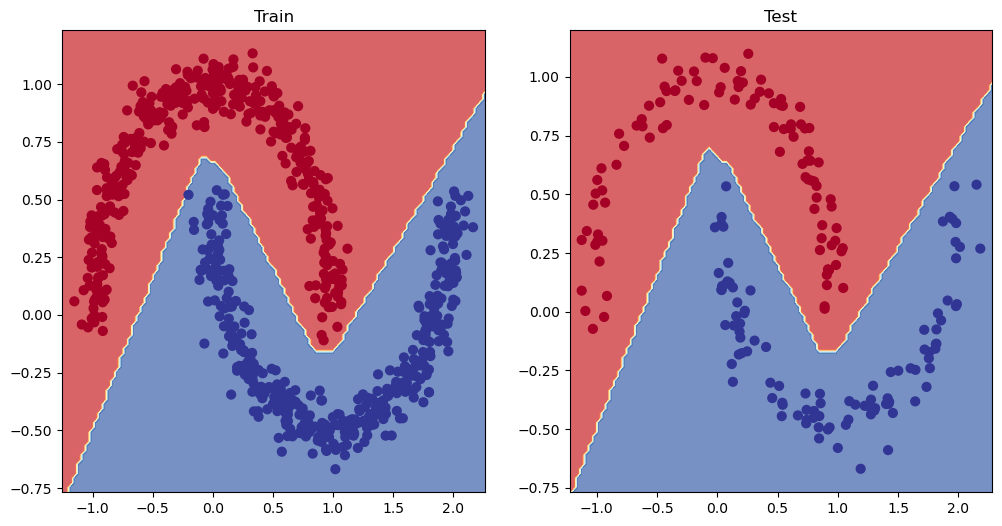

In [11]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_5, X_test, y_test)